In [1]:
import torch
import pickle

def load_tensor(i):
    
    # Path to the downloaded .pkl file
    file_path = 'tensor'+str(i)+'.pkl'
    
    # Load the tensor from the .pkl file
    with open(file_path, 'rb') as f:
        tensor = pickle.load(f)
    
    file_path = 'vector'+str(i)+'.pkl'
    
    # Load the tensor from the .pkl file
    with open(file_path, 'rb') as f:
        vector = pickle.load(f).to('cuda')
    return tensor, vector

In [2]:
def gradient(Q, b, a, m):

    c = Q @ b / m ## 
    g = Q.T @ (c - a) * 2 / m

    return g

In [3]:
import numpy as np
def optimal_project_to_simplex(b, m):
    # Step 1: Clip the vector to ensure it is between 0 and 1
    b = np.clip(b, 0, 1)
    
    # Step 2: Check if the sum is greater than m, if so scale it down
    sum_b = np.sum(b)
    if sum_b > m:
        return b * (m / sum_b)
        
    # Step 3: If the sum is less than m, sort the vector in descending order
    sorted_indices = np.argsort(-b)
    sorted_b = b[sorted_indices]
    
    # Step 4: Find the first index i that satisfies the conditions
    cumsum_sorted_b = np.cumsum(sorted_b)
    N = len(b)
    for i in range(N):
        if sorted_b[i] > 0 and (m - (i + 1)) / (cumsum_sorted_b[-1] - cumsum_sorted_b[i]) <= 1:
            break
    
    # Step 5: Set v_1, ..., v_i to 1
    sorted_b[:i + 1] = 1
    
    # Step 6: Scale remaining elements
    if i + 1 < N:
        remaining_sum = np.sum(sorted_b[i + 1:])
        if remaining_sum > 0:
            scale_factor = (m - (i + 1)) / remaining_sum
            sorted_b[i + 1:] *= scale_factor
    
    # Reorder to the original order
    b[sorted_indices] = sorted_b
    
    return b

In [4]:
import torch

def optimal_project_to_simplex_torch(b, m):
    # Step 1: Clip the vector to ensure it is between 0 and 1
    b = torch.clamp(b, 0, 1)
    
    # Step 2: Check if the sum is greater than m, if so scale it down
    sum_b = torch.sum(b)
    if sum_b > m:
        return b * (m / sum_b)
        
    # Step 3: If the sum is less than m, sort the vector in descending order
    sorted_b, sorted_indices = torch.sort(b, descending=True)
    
    # Step 4: Find the first index i that satisfies the conditions
    cumsum_sorted_b = torch.cumsum(sorted_b, dim=0)
    N = len(b)
    for i in range(N):
        if sorted_b[i] > 0 and (m - (i + 1)) / (cumsum_sorted_b[-1] - cumsum_sorted_b[i]) <= 1:
            break
    
    # Step 5: Set v_1, ..., v_i to 1
    sorted_b[:i + 1] = 1
    
    # Step 6: Scale remaining elements
    if i + 1 < N:
        remaining_sum = torch.sum(sorted_b[i + 1:])
        if remaining_sum > 0:
            scale_factor = (m - (i + 1)) / remaining_sum
            sorted_b[i + 1:] *= scale_factor
    
    # Reorder to the original order
    original_b = b.clone()
    original_b[sorted_indices] = sorted_b
    
    return original_b


In [5]:
Q, a = load_tensor(1)
d, N = Q.shape

m = 10000.0
#b = torch.ones(Q.shape[1]).to('cuda') / m
b = torch.rand(N, device='cuda')

#L = N / d * 2 / m**2

lr= 1.0

T = 1000
e = np.zeros(T)

for t in range(T):

    g = gradient(Q, b, a, m)
    b = b - lr * g
    b = optimal_project_to_simplex_torch(b, m)
    e[t] = torch.norm(1/m * Q @ b - a)

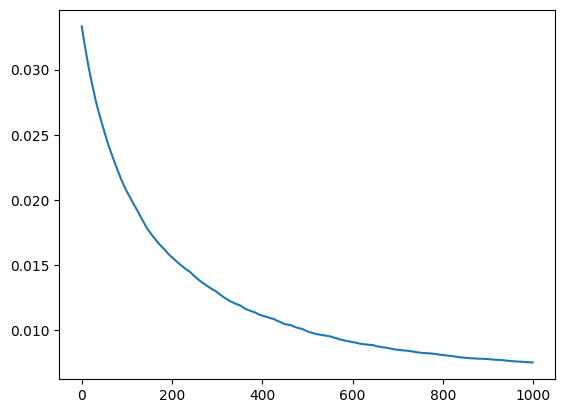

In [6]:
import matplotlib.pyplot as plt

plt.plot(e)

In [8]:
Q, a = load_tensor(1)
d, N = Q.shape

m = 10000.0
#b = torch.ones(Q.shape[1]).to('cuda') / m
b = torch.rand(N, device='cuda')

#L = N / d * 2 / m**2

lr= 1.0

T = 1000
e = np.zeros(T)

for t in range(T):

    g = torch.zeros(N, device='cuda')
    
    for i in range(1, 4):
        Q, a = load_tensor(i)
        g += gradient(Q, b, a, m)

    b = b - lr * g
    b = optimal_project_to_simplex_torch(b, m)
    
    for i in range(1, 4):
        Q, a = load_tensor(i)
        e[t] += torch.norm(1/m * Q @ b - a)

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

plt.plot(e)

In [5]:
Q1, a1 = load_tensor(1)
Q2, a2 = load_tensor(2)
Q3, a3 = load_tensor(3)

In [12]:
Q = torch.cat([Q1, Q2, Q3], dim = 0)
a = torch.cat([a1, a2, a3])

In [9]:
Q.shape

torch.Size([882, 23435200])

In [11]:
Q.is_sparse

True

In [61]:
d, N = Q.shape

m = 10000.0
#b = torch.ones(Q.shape[1]).to('cuda') / m
b = torch.rand(N, device='cuda')

l = largest_singular_value(Q)
L = l*l * 2 / (m*m)
lr= 1/L

T = 100
e = np.zeros(T)

for t in range(T):

    g = gradient(Q, b, a, m)
    b = b - lr * g
    b = optimal_project_to_simplex_torch(b, m)
    e[t] = torch.norm(1/m * Q @ b - a)

In [62]:
lr

11.892880845042551

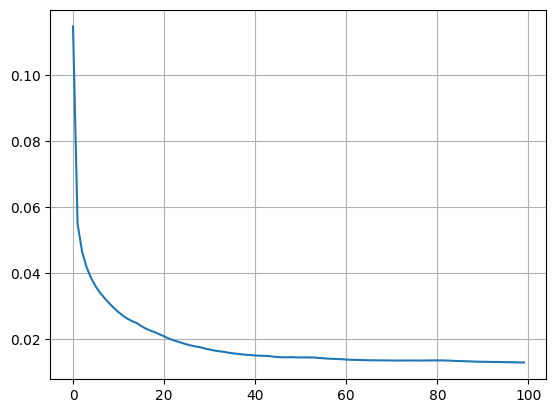

In [63]:
import matplotlib.pyplot as plt

plt.grid()
plt.plot(e)

In [17]:
d, N = Q.shape

m = 10000.0
b = torch.ones(Q.shape[1]).to('cuda') / m
#b = torch.rand(N, device='cuda')

#L = N / d * 2 / m**2

lr= 1.0

T = 1000
e = np.zeros(T)

for t in range(T):

    g = gradient(Q, b, a, m)
    b = b - lr * g
    b = optimal_project_to_simplex_torch(b, m)
    e[t] = torch.norm(1/m * Q @ b - a)

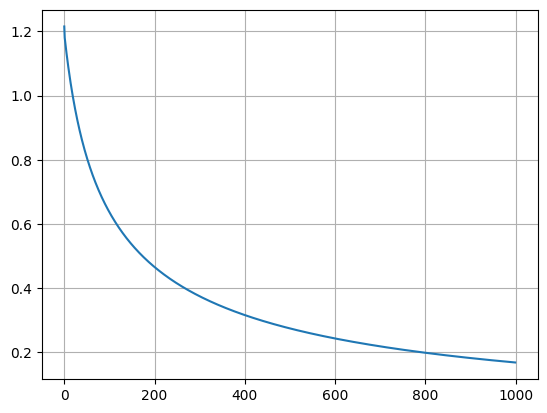

In [18]:
import matplotlib.pyplot as plt

plt.grid()
plt.plot(e)

In [28]:
A = Q @ Q.T

In [34]:
import torch

def largest_singular_value(sparse_tensor, tolerance=1e-6, max_iterations=1000):
    """
    Calculate the largest singular value of a sparse tensor using power iteration.
    
    Parameters:
    sparse_tensor (torch.sparse_coo_tensor): Input sparse tensor.
    tolerance (float): Desired error tolerance for convergence.
    max_iterations (int): Maximum number of iterations to perform.
    
    Returns:
    float: Approximation of the largest singular value.
    """
    # Ensure the input is a sparse tensor
    assert sparse_tensor.is_sparse, "Input tensor must be sparse"

    # Initialize a random vector
    N = sparse_tensor.size(1)
    b_k = torch.randn(N, device=sparse_tensor.device)
    b_k = b_k / torch.norm(b_k)  # Normalize the initial vector

    # Power iteration method to find the largest singular value
    singular_value_old = 0.0
    for _ in range(max_iterations):
        # Perform the matrix multiplication
        b_k1 = torch.sparse.mm(sparse_tensor, b_k.view(-1, 1)).view(-1)
        b_k1_norm = torch.norm(b_k1)
        b_k1 = b_k1 / b_k1_norm

        # Perform the matrix multiplication with the transpose
        b_k = torch.sparse.mm(sparse_tensor.t(), b_k1.view(-1, 1)).view(-1)
        b_k_norm = torch.norm(b_k)
        b_k = b_k / b_k_norm

        # Check for convergence
        if torch.abs(b_k_norm - singular_value_old) < tolerance:
            break
        singular_value_old = b_k_norm

    return b_k_norm.item()

In [35]:
largest_singular_value(Q)

2050.413818359375

In [36]:
largest_singular_value(Q.T)

2050.427978515625